## DNA structure prediction using Machine Learning

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Standard imports 

from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [118]:
import lightgbm as lgb
import torch
import torch.nn.functional as F
import pyro
from IPython.core.debugger import set_trace

In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [6]:
import optuna
import sklearn

In [43]:
import pandas as pd 
import numpy as np
import seaborn as sns
from imblearn.combine import SMOTETomek
import statistics
import shap
np.random.seed(42)
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
import os
from pathlib import Path
import glob
import regex
import dill
import gzip
import toolz, itertools, more_itertools
from collections import Counter, OrderedDict

In [9]:
import umap
import umap.plot

In [10]:
DIR = Path('/data/home/arnab/abhijit/jupyter/dna_structure_prediction_ml')
assert DIR.exists()
DATA = DIR/"data"

## Helper Functions

In [11]:
def feeder():
    with gzip.open(DATA/"pdb_seqres.txt.gz", "rt", newline="\n") as f:
        for line in iter(lambda: f.read(16777216), ""):
            yield line
            

In [12]:
def gen_grep(pattern, lines):
    pat = regex.compile(pattern, flags=regex.IGNORECASE | regex.MULTILINE)
    for line in lines:
        if seq:=pat.search(line):
            yield seq
            break
            

In [13]:
def read_pdb():
    lines=""
    for x in feeder():
        lines += x
    return lines

In [14]:
def dedupe(items, key=None):
    seen = set()
    for item in items:
        val = item if key is None else key(item)
        if val not in seen:
            yield (item, val)
            seen.add(val)

In [15]:
try:
    _file = DIR / "data"
    os.mkdir(_file / "pkl")
except FileExistsError:
    print("Dir exists")


def pkl_it(dataframe, filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "wb") as fh:
        dill.dump(dataframe, fh)
    return


def unpkl_it(filebase):
    with open(DIR / "data" / "pkl" / str(filebase + ".pkl"), "rb") as fh:
        return dill.load(fh)

Dir exists


In [ ]:
def get_data(file_contents):
    notfound = []
    A_dna = {}
    B_dna = {}
    for x in A_DNA["PDB ID"]:
        try:
            # filter out data
            A_dna[x] = regex.search(r"(?:>%s.+\n)(.+)\n" % x.lower(), file_contents).group(
                1
            )
        except:
            notfound.append(x)
            continue
    for x in B_DNA["PDB ID"]:
        try:
            # filter out
            B_dna[x] = regex.search(r"(?:>%s.+\n)(.+)\n" % x.lower(), file_contents).group(
                1
            )
        except:
            notfound.append(x)
            continue
    return A_dna, B_dna, notfound


In [ ]:
pdb_data = read_pdb()

In [ ]:
A_DNA = pd.read_csv(DATA/"A_DNA.csv")
B_DNA = pd.read_csv(DATA/"B_DNA.csv")

In [ ]:
A_DNA_report = pd.read_csv(DATA/"A_DNA_report.csv")
B_DNA_report = pd.read_csv(DATA/"B_DNA_report.csv")

In [ ]:
A_dna, B_dna, notfound = get_data(pdb_data)

In [ ]:
# pkl_it(A_dna, "A_dna")
# pkl_it(B_dna, "B_dna")

In [ ]:
A_DNA = dict(list(dedupe(A_dna, key=lambda x: A_dna[x])))
B_DNA = dict(list(dedupe(B_dna, key=lambda x: B_dna[x])))

In [16]:
def filter_out(data: dict):
    cleaned = {}

    def plausible_(seq): return len(seq) >= 5 and {"A", "T", "G", "C"}.union(
        Counter(seq).keys()) == {"A", "T", "G", "C"}
    for key in data:
        if plausible_(data[key]):
            cleaned[key] = data[key]
    return cleaned

In [ ]:
A_DNA = filter_out(A_DNA)
B_DNA = filter_out(B_DNA)

In [ ]:
# pkl_it(A_DNA, "A_DNA")
# pkl_it(B_DNA, "B_DNA")

In [17]:
B_DNA = unpkl_it("B_DNA")
A_DNA = unpkl_it("A_DNA")

In [18]:
len({x:A_DNA[x] for x in A_DNA if 5<len(A_DNA[x])< 13})

79

In [19]:
len({x:B_DNA[x] for x in B_DNA if 5<len(B_DNA[x])< 13})

195

In [20]:
data_A = {x:A_DNA[x] for x in A_DNA if 5<len(A_DNA[x])< 13}
data_B = {x:B_DNA[x] for x in B_DNA if 5<len(B_DNA[x])< 13}

In [21]:
import math
def positionalencoding1d(d_model, length):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

DICT = {'AA': 'AA/TT',
 'TT': 'AA/TT',
 'GG': 'GG/CC',
 'CC': 'GG/CC',
 'AC': 'AC/GT',
 'GT': 'AC/GT',
 'CA': 'CA/TG',
 'TG': 'CA/TG',
 'AT': 'AT/AT',
 'TA': 'TA/TA',
 'AG': 'AG/CT',
 'CT': 'AG/CT',
 'GA': 'GA/TC',
 'TC': 'GA/TC',
 'CG': 'CG/CG',
 'GC': 'GC/GC'}

def encoding(sequence):
    elems = ['AA/TT', 'GG/CC', 'AC/GT', 'CA/TG', 'AT/AT', 'TA/TA', 'AG/CT', 'GA/TC', 'CG/CG', 'GC/GC']
    c_ = Counter(elems)
    c_.subtract(elems) #set all to Zeros 
    dinucleotide_steps = [DICT["".join(x)] for x in more_itertools.windowed(sequence, 2, step=1)]
    c_.update(dinucleotide_steps)
    positions = positionalencoding1d(2, 12)
    return dinucleotide_steps, c_, positions[:len(dinucleotide_steps)]

    
    

In [22]:
def gen_dataSet(A_DNA, B_DNA):
    dataSet = OrderedDict()
    for x in B_DNA:
        try:
            if 5 < len(B_DNA[x]) < 13:
                dataSet[x] = (0, B_DNA[x], np.array([x_ for x_ in encoding(B_DNA[x])[1].values()]))
        except KeyError:
            print("B_DNA", x, " not found")
            continue
    for x in A_DNA:
        try:
            if 5 < len(A_DNA[x]) < 13:
                dataSet[x] = (1, A_DNA[x], np.array([x_ for x_ in encoding(A_DNA[x])[1].values()]))
        except KeyError:
            print("A_DNA", x, " not found")
            continue
    return dataSet

In [23]:
#dataSet = gen_dataSet(data_A, data_B)
dataSet = gen_dataSet(A_DNA, B_DNA)

In [24]:
len(data_A) + len(data_B)

274

In [25]:
len(dataSet)

274

In [30]:
print(f"A-DNA: {len(data_A)}, B-DNA: {len(data_B)}")

A-DNA: 79, B-DNA: 195


In [40]:
SCALE_POS_WEIGHT = lambda T,P: (100*(T-P)/T) / (100*P/T)

In [41]:
SCALE_POS_WEIGHT(195+79, 79)

2.4683544303797467

In [27]:
def create_df(dataset: dict):
    temp_df = pd.DataFrame.from_dict(dataset).T
    temp_df.columns = ["target", "sequence", "other"]
    df = pd.concat([temp_df.iloc[:, [0, 1]], temp_df.apply(
        lambda x: x[2], axis=1, result_type="expand")], axis=1)
    df.columns = ["target", "sequence", *['AA/TT', 'GG/CC', 'AC/GT',
                                          'CA/TG', 'AT/AT', 'TA/TA', 'AG/CT', 'GA/TC', 'CG/CG', 'GC/GC']]
    df["target"] = df["target"].astype(int)
    df["item"] = df.target.apply(lambda x: "B" if x==0 else "A")
    return df

In [28]:
data_df = create_df(dataSet)
#(create_df(dataSet).item == "B").sum()

In [164]:
data_df

,target,sequence,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC,item
6RSO,0,TCGGCGCCGA,0,2,0,0,0,0,0,2,3,2,B
6M5B,0,CCAGGCCTGG,0,4,0,2,0,0,2,0,0,1,B
6R14,0,CCTCAGGCCTCC,0,4,0,1,0,0,3,2,0,1,B
6QJR,0,CGCAAAAAAGCG,5,0,0,1,0,0,1,0,2,2,B
6ED9,0,TGGGCGGGA,0,4,0,1,0,0,0,1,1,1,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1D82,1,GTCTAGAC,0,0,2,0,0,1,2,2,0,0,A
1D26,1,GCCCGGGC,0,4,0,0,0,0,0,0,1,2,A
2D47,1,CCCCCGCGGGGG,0,8,0,0,0,0,0,0,2,1,A
1DN6,1,GGATGGGAG,0,3,0,1,1,0,1,2,0,0,A


In [194]:
def seq_similarity(sequence: str, n: int):
    return ("".join(x) for x in more_itertools.windowed(sequence, n))

In [224]:
def ranker(sequence: str, n: int, percentage: float):
    count_sub = Counter()
    count_sub.update(seq_similarity(sequence, n))
    #count_sub.most_common(3)
    length = len(count_sub)
    top_k = int(percentage*length/100)
    return count_sub.most_common(top_k)

In [228]:
ranker("GGGGCCCCGGGGGGGGAAAAG", 4,25)

[('GGGG', 6), ('GGGC', 1), ('GGCC', 1)]

In [246]:
for _ in data_df.sequence.apply(lambda seq: ranker(seq,4, 30)).values:
    try:
        print(_[0], _[1])
    except IndexError:
        print("too few")

('TCGG', 1) ('CGGC', 1)
('CCAG', 1) ('CAGG', 1)
('CCTC', 2) ('CTCA', 1)
('AAAA', 3) ('CGCA', 1)
too few
('CCAG', 1) ('CAGC', 1)
too few
too few
too few
('CGCG', 2) ('GCGA', 1)
too few
too few
('AATT', 2) ('CGAA', 1)
('CGTG', 1) ('GTGA', 1)
('TGGA', 2) ('GGAA', 2)
('TTTT', 3) ('CGAT', 1)
('GCAT', 1) ('CATC', 1)
too few
too few
too few
too few
too few
('GATG', 1) ('ATGA', 1)
('CTAG', 1) ('TAGC', 1)
too few
too few
too few
too few
('CGCT', 1) ('GCTA', 1)
('CGCA', 1) ('GCAA', 1)
too few
('GGAC', 1) ('GACT', 1)
too few
too few
('TCGG', 1) ('CGGT', 1)
('CGAC', 1) ('GACG', 1)
('CGCA', 1) ('GCAA', 1)
('CGAC', 1) ('GACT', 1)
too few
too few
('CGCG', 2) ('GCGA', 1)
('CGCG', 1) ('GCGT', 1)
('AATA', 1) ('ATAA', 1)
too few
('CGAA', 1) ('GAAA', 1)
too few
too few
too few
('CGTC', 1) ('GTCG', 1)
too few
too few
('CCGA', 1) ('CGAT', 1)
('GTCC', 1) ('TCCA', 1)
('GCTA', 1) ('CTAG', 1)
('CGGA', 1) ('GGAA', 1)
('CGGG', 1) ('GGGT', 1)
('CGTA', 1) ('GTAC', 1)
('CGCG', 2) ('GCGA', 1)
('CGCG', 2) ('GCGA', 1)


In [31]:
pkl_it(data_df, "data_df")

In [32]:
data_df_unique = data_df.drop_duplicates(subset=['AA/TT', 'GG/CC', 'AC/GT',
                                          'CA/TG', 'AT/AT', 'TA/TA', 'AG/CT', 'GA/TC', 'CG/CG', 'GC/GC'], keep='last')

In [33]:
pkl_it(data_df_unique, "data_df_unique")

In [ ]:
train = pd.read_csv(DATA/"train_data.csv",index_col=0)
test = pd.read_csv(DATA/"test_data.csv", index_col=0)
data = pd.concat([train, test])

In [122]:
def corr_plot(df):
    corr = df.corr()
    return corr.style.background_gradient(cmap="coolwarm", axis=None).set_precision(
        2).set_properties(**{'font-size': '14pt'}).set_caption('Class-Conditional feature correlation').set_table_styles([
            {'selector': 'caption',
             'props': [
                 ('color', 'black'),
                 ('font-size', '16px')]}
        ])

In [123]:
corr_plot(data_df_unique.query('target==1').drop("target", axis=1)) #A-DNA

,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC
AA/TT,1.00,-0.18,-0.15,0.04,0.05,-0.12,-0.01,0.21,0.05,0.03
GG/CC,-0.18,1.00,-0.39,-0.18,-0.10,-0.39,-0.12,-0.14,-0.19,-0.30
AC/GT,-0.15,-0.39,1.00,0.06,-0.23,0.55,-0.21,-0.12,0.19,-0.31
CA/TG,0.04,-0.18,0.06,1.00,0.44,-0.28,-0.22,-0.18,-0.29,0.15
AT/AT,0.05,-0.10,-0.23,0.44,1.00,-0.10,-0.15,0.08,-0.17,0.07
TA/TA,-0.12,-0.39,0.55,-0.28,-0.10,1.00,0.35,-0.26,0.08,-0.18
AG/CT,-0.01,-0.12,-0.21,-0.22,-0.15,0.35,1.00,0.24,-0.36,-0.12
GA/TC,0.21,-0.14,-0.12,-0.18,0.08,-0.26,0.24,1.00,-0.14,-0.34
CG/CG,0.05,-0.19,0.19,-0.29,-0.17,0.08,-0.36,-0.14,1.00,0.44
GC/GC,0.03,-0.30,-0.31,0.15,0.07,-0.18,-0.12,-0.34,0.44,1.00


In [124]:
corr_plot(data_df_unique.query('target==0').drop("target", axis=1)) #B-DNA

,AA/TT,GG/CC,AC/GT,CA/TG,AT/AT,TA/TA,AG/CT,GA/TC,CG/CG,GC/GC
AA/TT,1.00,-0.26,-0.17,-0.04,0.04,-0.09,-0.20,-0.27,-0.08,-0.08
GG/CC,-0.26,1.00,-0.02,-0.03,-0.31,-0.22,0.05,-0.11,-0.10,-0.09
AC/GT,-0.17,-0.02,1.00,0.20,-0.33,0.04,-0.14,-0.03,0.13,-0.25
CA/TG,-0.04,-0.03,0.20,1.00,0.05,-0.22,-0.03,-0.27,-0.42,0.12
AT/AT,0.04,-0.31,-0.33,0.05,1.00,0.55,-0.33,0.04,-0.07,-0.09
TA/TA,-0.09,-0.22,0.04,-0.22,0.55,1.00,-0.01,-0.24,-0.06,-0.14
AG/CT,-0.20,0.05,-0.14,-0.03,-0.33,-0.01,1.00,0.30,-0.39,-0.01
GA/TC,-0.27,-0.11,-0.03,-0.27,0.04,-0.24,0.30,1.00,0.19,-0.22
CG/CG,-0.08,-0.10,0.13,-0.42,-0.07,-0.06,-0.39,0.19,1.00,0.37
GC/GC,-0.08,-0.09,-0.25,0.12,-0.09,-0.14,-0.01,-0.22,0.37,1.00


In [ ]:
mapper = umap.UMAP(random_state=42).fit(data_df_unique.drop(labels=["target", "sequence", "item"], axis=1))
hover_data = pd.DataFrame({'index':data_df_unique.index,
                           'label':data_df_unique.target.values})
hover_data['item'] = hover_data.label.map(
    {
        0:'B-DNA',
        1:'A-DNA',
    }
)

In [ ]:
p = umap.plot.interactive(mapper, labels=hover_data.item, hover_data=hover_data, point_size=5)
umap.plot.show(p)

In [ ]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

In [ ]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')

In [ ]:
umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=60,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(dataFinal.drop(labels=["target", "sequence", "item"], axis=1))

In [ ]:
plt.close()
plt.figure()
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=data_df_unique.target, s=5, cmap='Spectral');

In [59]:
def gen_data(data: pd.DataFrame, RESAMPLING: bool=True):
    X, y = data.drop(labels="target", axis=1), data["target"]
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.20, random_state=42)
    for train_index, val_index in sss.split(X, y):
        yield {"X_train": X_resampled if RESAMPLING else X.iloc[train_index,:],
               "y_train": y_resampled if RESAMPLING else y.iloc[train_index],
              "X_val": X.iloc[val_index,:], "y_val": y.iloc[val_index]}

In [62]:
def gen_data_for_tuningHP(data: dict, RESAMPLING: bool=True):
    
    X, y = data["X_train"], data["y_train"]
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=42)
    for train_index, val_index in sss.split(X, y):
        smote_tomek = SMOTETomek(random_state=42)
        X_resampled, y_resampled = smote_tomek.fit_resample(elem["X_train"], elem["y_train"])
        yield {"X_train": X_resampled if RESAMPLING else X.iloc[train_index,:],
               "y_train": y_resampled if RESAMPLING else y.iloc[train_index],
               "X_val": X.iloc[val_index,:], "y_val": y.iloc[val_index]}
    

In [60]:

for idx, elem in enumerate(gen_data(data_df_unique.drop(labels=["item","sequence"], axis=1))):
#     smote_tomek = SMOTETomek(random_state=42)
#     X_resampled, y_resampled = smote_tomek.fit_resample(elem["X_train"], elem["y_train"])
    break
    

In [ ]:
# def trainer(data, param_updater):
#     #data, target = X_train, y_train
#     train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]
#     dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=True)
#     dvalid = lgb.Dataset(valid_x, label=valid_y, free_raw_data=True)
#     watchlist = [dtrain, dvalid]
#     #watchlist = [dtrain]
#     param = {
#         "objective": "binary",
#         "seed": 1,
#         "metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "learning_rate": 0.1,
#         "scale_pos_weight": 2.0,
#     }
#     param.update(param_updater)
#     model = lgb.train(param, dtrain,
#                     num_boost_round=30,
#                     valid_sets=watchlist,
#                     early_stopping_rounds=10,
#                     verbose_eval=False,
#                     )
#     return model
    

In [63]:
def accuracy_T(idx):
    y_pred_valid = models[idx].predict(elem["X_val"])
    pred_labels = np.rint(y_pred_valid)
    accuracy = sklearn.metrics.accuracy_score(elem["y_val"], pred_labels)
    mcc = sklearn.metrics.balanced_accuracy_score(elem["y_val"], pred_labels)
    auc = sklearn.metrics.roc_auc_score(elem["y_val"], y_pred_valid)
    return accuracy, mcc, auc

In [64]:
def acc_f(models, data):
    data_ = {}
    for idx, model in enumerate(models):
        #print(len(data["y_val"]))
        y_pred_val = model.predict(data["X_val"])
        pred_labels = np.rint(y_pred_val)
        accuracy = sklearn.metrics.accuracy_score(data["y_val"], pred_labels)
        mcc = sklearn.metrics.balanced_accuracy_score(data["y_val"], pred_labels)
        auc = sklearn.metrics.roc_auc_score(data["y_val"], y_pred_val)
        data_[idx] = {"Accuracy": accuracy, "MCC": mcc, "AUC": auc}
    return data_
        
        

In [154]:
# def trainer(data, param_updater):
#     #data, target = X_train, y_train
#     train_x, train_y = data["X_train"], data["y_train"]
#     dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=True)
#     watchlist = [dtrain, ]
#     param = {
#         "objective": "binary",
#         "seed": 42,
#         "metric": "auc",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "learning_rate": 0.1,
#         "scale_pos_weight": SCALE_POS_WEIGHT(195+79, 79),
#     }
#     param.update(param_updater)
#     model = lgb.train(param, dtrain,
#                     num_boost_round=25,
#                     valid_sets=watchlist,
#                     early_stopping_rounds=10,
#                     verbose_eval=False,
#                     )
#     return model
    

In [161]:
def trainer(data, param_updater):
    #data, target = X_train, y_train
    train_x, train_y = data["X_train"], data["y_train"]
    dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=True)
    watchlist = [dtrain, ]
    param = {
        "objective": "binary",
        "seed": 42,
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "scale_pos_weight": np.sqrt(SCALE_POS_WEIGHT(195+79, 79)),
    }
    param.update(param_updater)
    model = lgb.train(param, dtrain,
                    num_boost_round=100,
                    valid_sets=watchlist,
                    early_stopping_rounds=10,
                    verbose_eval=False,
                    )
    return model
    

In [ ]:
# import optuna

# import copy

# def objective(data, metric, trial):
#     #data, target = X_train, y_train
#     train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]
#     dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=True)
#     dvalid = lgb.Dataset(valid_x, label=valid_y, free_raw_data=True)
#     watchlist = [dtrain, dvalid]
#     param = {
#         "objective": "binary",
#         "seed": 42,
#         "metric": metric,
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "learning_rate": 0.1,
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "scale_pos_weight": 2.0,
#     }
    
# #     pruning_callback = optuna.integration.LightGBMPruningCallback(
# #                                 trial, metric, valid_name='valid_1')
    
#     model = lgb.train(param, dtrain,
#                     num_boost_round=1000,
#                     valid_sets=watchlist,
#                     early_stopping_rounds=70,
#                     #callbacks=[pruning_callback],
#                     verbose_eval=True,
#                     )
#     y_pred_valid = model.predict(valid_x, num_iteration=model.best_iteration)
#     pred_labels = np.rint(y_pred_valid)
#     accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
#     balanced_accuracy = sklearn.metrics.balanced_accuracy_score(valid_y, pred_labels)
#     f1 = sklearn.metrics.f1_score(valid_y, pred_labels)
#     mcc = sklearn.metrics.matthews_corrcoef(valid_y, pred_labels)
#     #print(f" Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy}, MCC: {mcc}")
#     log = {f'train/{metric}': model.best_score['training'][metric],
#            f'valid/{metric}': model.best_score['valid_1'][metric]}
#     return f1


In [147]:
import optuna

import copy

def objective(data, metric, trial):
    #data, target = X_train, y_train
    train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]
    dtrain = lgb.Dataset(train_x, label=train_y, free_raw_data=True)
    dvalid = lgb.Dataset(valid_x, label=valid_y, free_raw_data=True)
    watchlist = [dtrain, dvalid]
    param = {
        "objective": "binary",
        "seed": 42,
        "metric": metric,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "scale_pos_weight": SCALE_POS_WEIGHT(195+79, 79),
    }
    
    pruning_callback = optuna.integration.LightGBMPruningCallback(
                                trial, metric, valid_name='valid_1')
    
    model = lgb.train(param, dtrain,
                    num_boost_round=200,
                    valid_sets=watchlist,
                    early_stopping_rounds=30,
                    callbacks=[pruning_callback],
                    verbose_eval=False,
                    )
    y_pred_valid = model.predict(valid_x, num_iteration=model.best_iteration)
    pred_labels = np.rint(y_pred_valid)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(valid_y, pred_labels)
    f1 = sklearn.metrics.f1_score(valid_y, pred_labels)
    mcc = sklearn.metrics.matthews_corrcoef(valid_y, pred_labels)
    #print(f" Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy}, MCC: {mcc}")
    log = {f'train/{metric}': model.best_score['training'][metric],
           f'valid/{metric}': model.best_score['valid_1'][metric]}
    return log[f'valid/{metric}']



# study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
#                             direction="minimize")
# study.optimize((toolz.curry(objective)(elem)("binary_error")), n_trials=250)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [ ]:
# from sklearn.metrics import roc_curve
# from matplotlib import pyplot
# # generate dataset

# def ROC(data: dict, model, idx):
#     y_pred_val = model.predict(data["X_val"])
#     fpr, tpr, thresholds = roc_curve(data["y_val"], y_pred_val)
#     # calculate the g-mean for each threshold
#     gmeans = np.sqrt(tpr * (1-fpr))
# #     print(gmeans)
# #     print(np.argmax(gmeans))
# #     print(thresholds)
#     # locate the index of the largest g-mean
#     ix = np.argmax(gmeans)
#     print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# #     plt.close()
# #     plt.figure()
#     plt.plot([0,1], [0,1], linestyle='--', label='Random choice')
#     plt.plot(fpr, tpr, marker='.', label=f'LGBM_model{idx}')
#     plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
#     # axis labels
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.legend()
#     # show the plot
#     #plt.show()
    

In [85]:
plt.close()
# fig = plt.figure(2)
# ax = fig.add_subplot(1, 1, 1)
# _ = ax.plot(np.arange(10))
# _ = ax.plot(np.arange(30))

In [148]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
# generate dataset

def call_ROC():
    plt.close()
    plt.figure(1)
    plt.plot([0,1], [0,1], linestyle='--', label='Random choice')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    def ROC(data: dict, model, idx):
        y_pred_val = model.predict(data["X_val"])
        fpr, tpr, thresholds = roc_curve(data["y_val"], y_pred_val)
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1-fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
        print("Accuracy: ", sklearn.metrics.accuracy_score(data["y_val"], np.where(y_pred_val > thresholds[ix], 1, 0)))
        plt.plot(fpr, tpr, marker='.', label=f'model{idx}: AUC={gmeans[ix]:.2f} at {thresholds[ix]:.3f}')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black',)
        # axis labels
        plt.legend()
          
        # show the plot
        #plt.show()
    return ROC
    

In [128]:
import collections
Trial = collections.namedtuple("Trial",["value", "parameters"])

In [ ]:

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# results = []
# outer_models = {}
# best_models = {}
# # *************OUTER*************
# plot_ROC = call_ROC()
# for outer_idx, elem in enumerate(gen_data(data_df_unique.drop(labels=["item", "sequence"], axis=1))):

#     study_dict = {}
#     # ***********INNER************
#     for idx, data_in in enumerate(gen_data_for_tuningHP(elem)):
        
#         study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
#                             direction="maximize")
#         study.optimize((toolz.curry(objective)(data_in)("auc")), n_trials=100)

#         print("Number of finished trials: {}".format(len(study.trials)))

#         trial = study.best_trial
#         study_dict[idx] = Trial(trial.value, trial.params)
#     arg_max = max(study_dict, key=lambda d: study_dict[d].value) #max for AUC
#     best_models[outer_idx] = trainer(elem, study_dict[arg_max].parameters)
    
#     plot_ROC(elem, best_models[outer_idx], outer_idx)
# #     models = {}
# #     results_outer = []
# #     for idx, tuned_params in enumerate(study_dict):
# #         models[idx] = trainer(elem, tuned_params)
# #         print(accuracy_T(idx))
# #         results_outer.append(accuracy_T(idx))
# #         outer_models.append(models[idx])
# #     results.append(np.array(results_outer).max(axis=0)) #choose the best
# #     best_models.append(models[np.array(results_outer).argmax(axis=0)[2]])
    
        
    

<IPython.core.display.Javascript object>


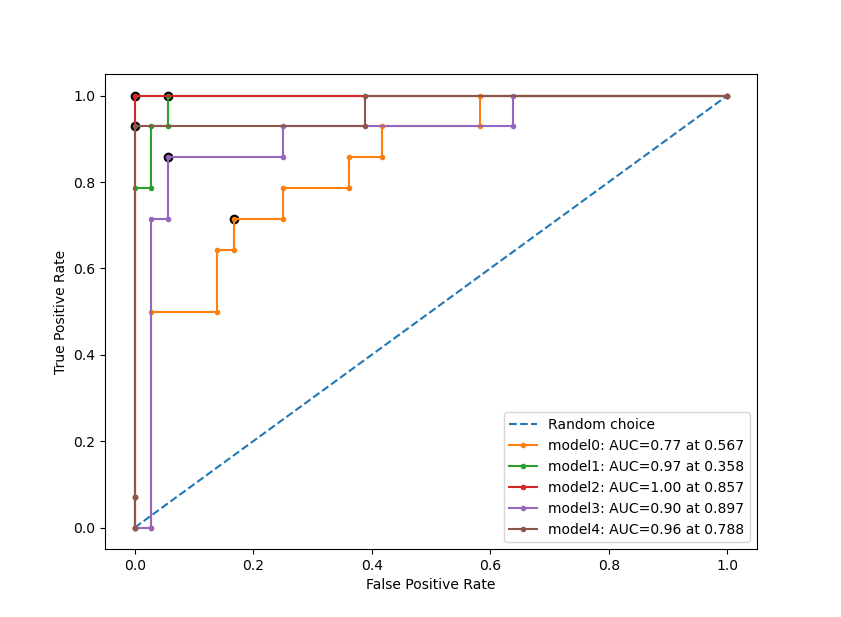

invalid value encountered in double_scalars


Number of finished trials: 100


invalid value encountered in double_scalars


Number of finished trials: 100
Best Threshold=0.567491, G-Mean=0.772
Accuracy:  0.78
Number of finished trials: 100


invalid value encountered in double_scalars


Number of finished trials: 100
Best Threshold=0.357641, G-Mean=0.972
Accuracy:  0.94


invalid value encountered in double_scalars


Number of finished trials: 100


invalid value encountered in double_scalars


Number of finished trials: 100
Best Threshold=0.857321, G-Mean=1.000
Accuracy:  0.98


invalid value encountered in double_scalars


Number of finished trials: 100


invalid value encountered in double_scalars
Mean of empty slice


Number of finished trials: 100
Best Threshold=0.896588, G-Mean=0.900
Accuracy:  0.9


invalid value encountered in double_scalars


Number of finished trials: 100


invalid value encountered in double_scalars


Number of finished trials: 100
Best Threshold=0.787816, G-Mean=0.964
Accuracy:  0.96


In [162]:

optuna.logging.set_verbosity(optuna.logging.WARNING)
results = []
outer_models = {}
best_models = {}
# *************OUTER*************
plot_ROC = call_ROC()
for outer_idx, elem in enumerate(gen_data(data_df_unique.drop(labels=["item", "sequence"], axis=1))):

    study_dict = {}
    # ***********INNER************
    for idx, data_in in enumerate(gen_data_for_tuningHP(elem)):
        
        study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="maximize")
        study.optimize((toolz.curry(objective)(data_in)("auc")), n_trials=100)

        print("Number of finished trials: {}".format(len(study.trials)))

        trial = study.best_trial
        study_dict[idx] = Trial(trial.value, trial.params)
    arg_max = max(study_dict, key=lambda d: study_dict[d].value) #max for AUC
    best_models[outer_idx] = trainer(elem, study_dict[arg_max].parameters)
    
    plot_ROC(elem, best_models[outer_idx], outer_idx)


In [163]:
(0.78+0.94+0.98+0.9+0.96)/5

0.9120000000000001

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [111]:
#sklearn_paramsLGBM = copy.deepcopy(best_models[outer_idx].params)

In [110]:
#sklearn_paramsLGBM.pop("early_stopping_round")

In [103]:
#clf_lgbm = lgb.LGBMClassifier(**sklearn_paramsLGBM)

<IPython.core.display.Javascript object>


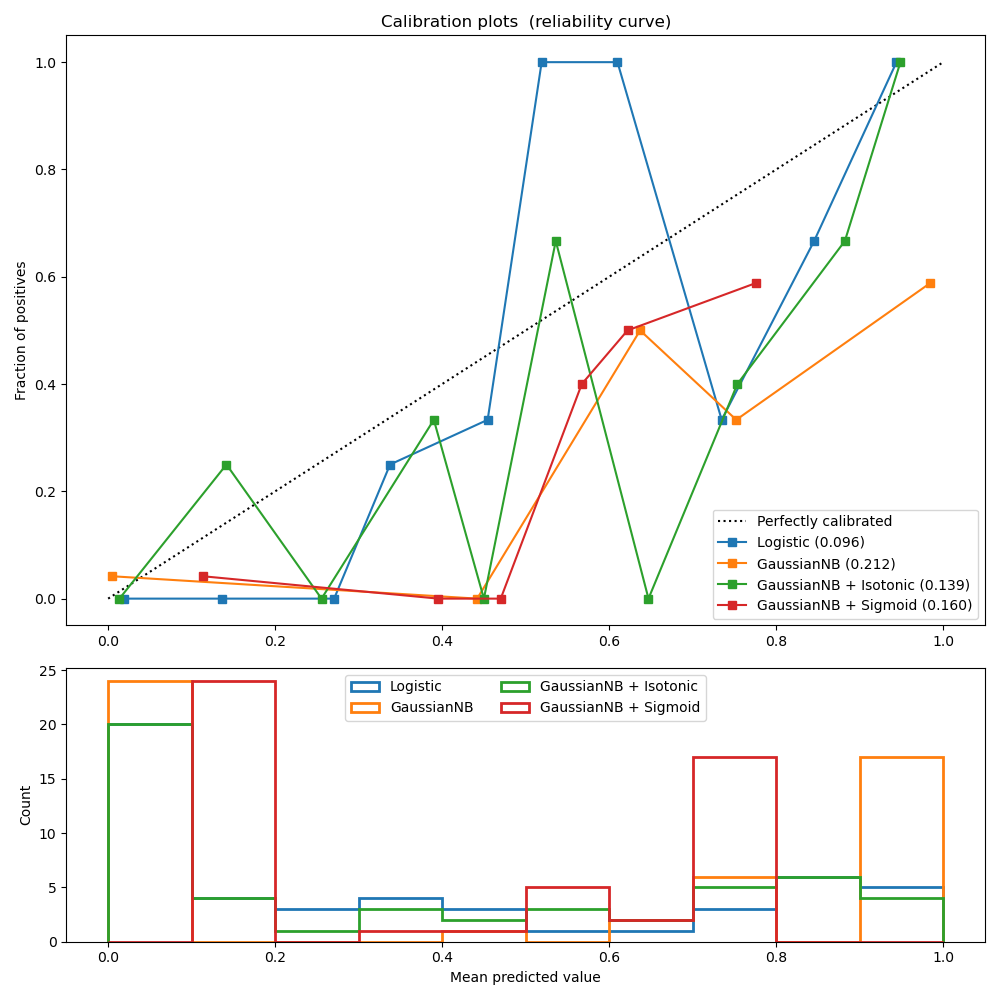

Logistic:
	Brier: 0.096
	Precision: 0.750
	Recall: 0.857
	F1: 0.800

GaussianNB:
	Brier: 0.212
	Precision: 0.520
	Recall: 0.929
	F1: 0.667

GaussianNB + Isotonic:
	Brier: 0.139
	Precision: 0.600
	Recall: 0.857
	F1: 0.706

GaussianNB + Sigmoid:
	Brier: 0.160
	Precision: 0.542
	Recall: 0.929
	F1: 0.684



<IPython.core.display.Javascript object>


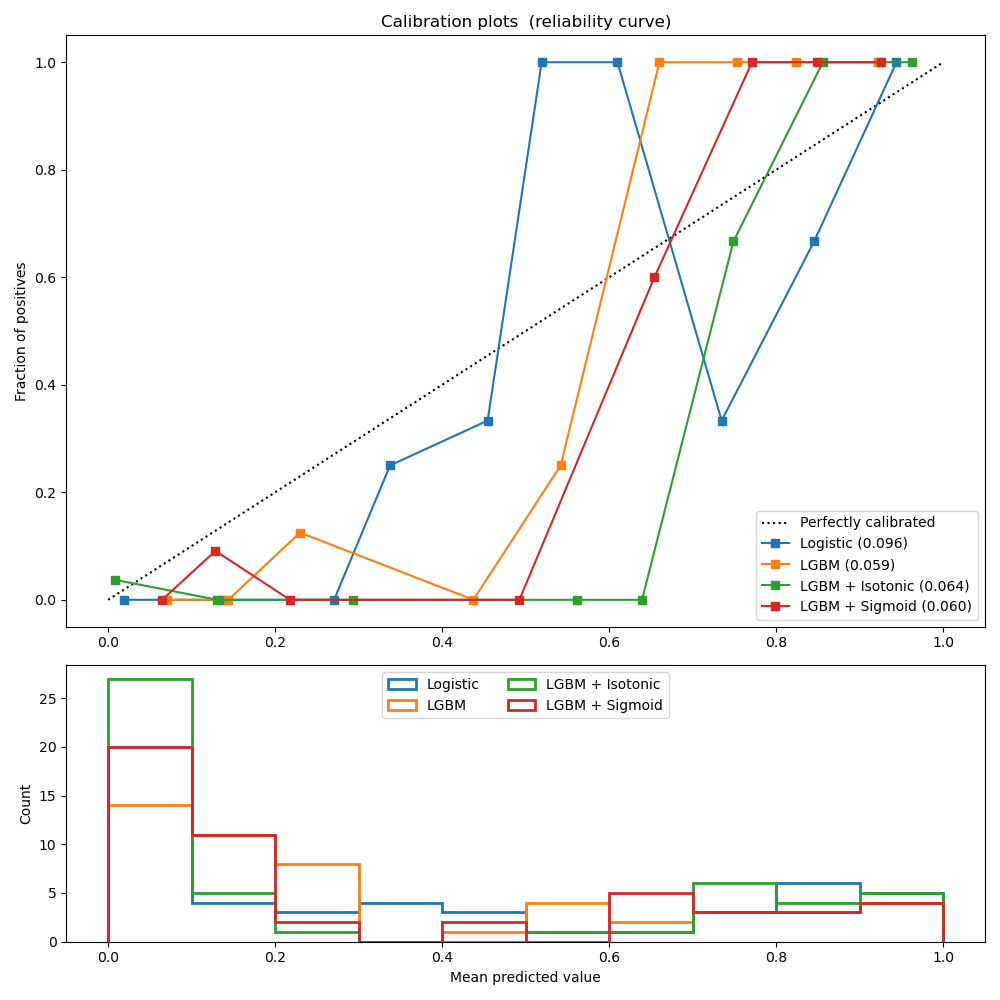

Logistic:
	Brier: 0.096
	Precision: 0.750
	Recall: 0.857
	F1: 0.800



Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074
LGBM:
	Brier: 0.059
	Precision: 0.812
	Recall: 0.929
	F1: 0.867



Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074
LGBM + Isotonic:
	Brier: 0.064
	Precision: 0.765
	Recall: 0.929
	F1: 0.839



Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.6056408848163332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6056408848163332
[LightGBM] [Warning] bagging_fraction is set=0.8716805610379103, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8716805610379103
[LightGBM] [Warning] lambda_l2 is set=0.0005468883112938826, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005468883112938826
[LightGBM] [Warning] lambda_l1 is set=0.00040801969662208074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00040801969662208074
LGBM + Sigmoid:
	Brier: 0.060
	Precision: 0.867
	Recall: 0.929
	F1: 0.897



In [115]:
# from sklearn.svm import LinearSVC
# from sklearn.naive_bayes import GaussianNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
#                              f1_score)
# from sklearn.calibration import CalibratedClassifierCV, calibration_curve
# from sklearn.model_selection import train_test_split

# def plot_calibration_curve(est, name, data, fig_index):
#     X_train, y_train, X_test, y_test = data["X_train"], data["y_train"], data["X_val"], data["y_val"]
#     """Plot calibration curve for est w/o and with calibration. """
#     # Calibrated with isotonic calibration
#     isotonic = CalibratedClassifierCV(est, cv=5, method='isotonic')

#     # Calibrated with sigmoid calibration
#     sigmoid = CalibratedClassifierCV(est, cv=5, method='sigmoid')

#     # Logistic regression with no calibration as baseline
#     lr = LogisticRegression(C=1.)

#     fig = plt.figure(fig_index, figsize=(10, 10))
#     ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
#     ax2 = plt.subplot2grid((3, 1), (2, 0))

#     ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
#     for clf, name in [(lr, 'Logistic'),
#                       (est, name),
#                       (isotonic, name + ' + Isotonic'),
#                       (sigmoid, name + ' + Sigmoid')]:
#         clf.fit(X_train, y_train)
#         y_pred = clf.predict(X_test)
#         if hasattr(clf, "predict_proba"):
#             prob_pos = clf.predict_proba(X_test)[:, 1]
#         else:  # use decision function
#             prob_pos = clf.decision_function(X_test)
#             prob_pos = \
#                 (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

#         clf_score = brier_score_loss(y_test, prob_pos, pos_label=1)
#         print("%s:" % name)
#         print("\tBrier: %1.3f" % (clf_score))
#         print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
#         print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
#         print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

#         fraction_of_positives, mean_predicted_value = \
#             calibration_curve(y_test, prob_pos, n_bins=10)

#         ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
#                  label="%s (%1.3f)" % (name, clf_score))

#         ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
#                  histtype="step", lw=2)

#     ax1.set_ylabel("Fraction of positives")
#     ax1.set_ylim([-0.05, 1.05])
#     ax1.legend(loc="lower right")
#     ax1.set_title('Calibration plots  (reliability curve)')

#     ax2.set_xlabel("Mean predicted value")
#     ax2.set_ylabel("Count")
#     ax2.legend(loc="upper center", ncol=2)

#     plt.tight_layout()

# # Plot calibration curve for Gaussian Naive Bayes
# plot_calibration_curve(GaussianNB(), "GaussianNB", elem, 1)

# # Plot calibration curve for Linear SVC
# plot_calibration_curve(clf_lgbm, "LGBM", elem, 2)

# plt.show()

In [ ]:
# import pprint
# #outer_fold_collect = {}
# for idx, elem in enumerate(gen_data(data_df_unique.drop(labels=["item", "sequence"], axis=1))):
#     #pprint.pprint(acc_f(outer_models, elem))
#     #outer_fold_collect[f"{idx}"]=pd.DataFrame(acc_f(outer_models, elem)).T
    

In [ ]:
multi_df = pd.concat(outer_fold_collect)

In [ ]:
multi_df

In [ ]:
 multi_df.mean(level=0, axis=0)

In [ ]:
models

In [ ]:
outer_models[-1]

In [ ]:
acc_f(outer_models, elem)

In [ ]:
dff = (pd.DataFrame.from_dict(acc_f(outer_models, elem)).T)
cm = sns.light_palette("orange", as_cmap=True)
dff.style.set_properties(**{'max-width': '150px', 'font-size': '12pt'}
                         ).set_precision(2).\
            background_gradient(cm, axis=None).\
            set_caption(f'Mean:{"     ".join([str(x)[:4] for x in dff.mean(axis=0).values]):}').\
            set_table_styles([
            {'selector': 'caption',
             'props': [
                 ('color', 'black'),
                 ('font-size', '12px')]}
        ])

In [ ]:
dff.std(axis=0)

In [ ]:
accuracy_T(1)

In [ ]:
models[1].best_score

In [ ]:
models[2].best_score

In [ ]:
# _ = trainer(data_in, {'lambda_l1': 2.245980260864227e-06,
#  'lambda_l2': 0.008861479330929107,
#  'num_leaves': 33,
#  'feature_fraction': 0.9810065932523065,
#  'bagging_fraction': 0.8137742489537305,
#  'bagging_freq': 2,
#  'min_child_samples': 14})

In [ ]:
study.best_params

In [ ]:
# import optuna


# # FYI: Objective functions can take additional arguments
# # (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
# def objective(data, trial):
#     #data, target = X_train, y_train
#     train_x, valid_x, train_y, valid_y = data["X_train"], data["X_val"], data["y_train"], data["y_val"]
#     dtrain = lgb.Dataset(train_x, label=train_y)
#     dvalid = lgb.Dataset(valid_x, label=valid_y)
#     watchlist = [dtrain, dvalid]
#     param = {
#         "objective": "binary",
#         "seed": 42,
#         "metric": "binary_error",
#         "verbosity": -1,
#         "boosting_type": "gbdt",
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#     }
    
#     pruning_callback = optuna.integration.LightGBMPruningCallback(
#                                 trial, 'binary_error', valid_name='valid_1')
    
#     model = lgb.train(param, dtrain,
#                     num_boost_round=1000,
#                     valid_sets=watchlist,
#                     early_stopping_rounds=100,
#                     callbacks=[pruning_callback],
#                     verbose_eval=True,
#                     )
#     y_pred_valid = model.predict(valid_x, num_iteration=model.best_iteration)
#     pred_labels = np.rint(y_pred_valid)
#     accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
#     balanced_accuracy = sklearn.metrics.balanced_accuracy_score(valid_y, pred_labels)
#     mcc = sklearn.metrics.matthews_corrcoef(valid_y, pred_labels)
#     print(f" Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy}, MCC: {mcc}")
#     log = {'train/binary_error': model.best_score['training']['binary_error'],
#            'valid/binary_error': model.best_score['valid_1']['binary_error']}
#     return log['valid/binary_error']



# study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
#                             direction="minimize")
# study.optimize((toolz.curry(objective)(data_in)), n_trials=100)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [ ]:
trial.params

In [ ]:
plt.close()
optuna.visualization.plot_optimization_history(study)


In [ ]:
plt.close()
optuna.visualization.plot_intermediate_values(study)

In [ ]:
"""
Number of finished trials: 100
Best trial:
  Value: 0.9273182957393483
  Params: 
    lambda_l1: 0.015116653748541988
    lambda_l2: 1.2128713727369085e-06
    num_leaves: 112
    feature_fraction: 0.7691649692125324
    bagging_fraction: 0.9835151742653666
    bagging_freq: 2
    min_child_samples: 11
"""

In [ ]:
[1,2][1,2,3]